### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import gensim
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

pd.set_option("display.max_colwidth", 200)

Using TensorFlow backend.


### Helper functions

In [217]:


def plot_model_metric(result_df,metric,title):
    plt.figure(figsize=(16,9));
    g = sns.barplot(x='Method',y=metric,hue='Model',data=results[['Method','Model',metric]]);

    for p in g.patches:
        g.annotate(format(100*p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center',
                   va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')
    g.set_yticklabels([]);
    g.axes.get_yaxis().set_visible(False)
    g.set_title(title);

def extract_results_from_models(method,model_dict,actual,test):
    cols = ['Method','Model','TrainAcc','CVAcc','TestAcc','TestF1','TestRecall','TestPrecision','TestROC_AUC']
    res_df = pd.DataFrame(columns=cols)
    
    for model_name,model in model_dict.items():

        model_cv_df = pd.DataFrame(model.cv_results_)
        best_row = model_cv_df[model_cv_df.rank_test_score==1]
        train_acc = float(best_row.mean_train_score)
        cv_acc = float(best_row.mean_test_score)
        
        if model_name == 'SVM':
            pred_margins = model.best_estimator_.decision_function(test)
            pred_neg = (pred_margins - pred_margins.min())/(pred_margins.max() - pred_margins.min())
        else:    
            preds_neg = model.best_estimator_.predict_proba(test)[:,0]
        
        test_acc,test_f1,test_recall,test_precision,test_auc = get_metrics(actual,preds_neg)
        
        model_metrics = {'Method':method,
               'Model':model_name,
               'TrainAcc':train_acc,
               'CVAcc':cv_acc,
               'TestAcc':test_acc,
                'TestF1':test_f1,
                'TestRecall':test_recall,
                'TestPrecision':test_precision,
                'TestROC_AUC':test_auc}
        res_df = res_df.append(model_metrics,ignore_index=True)
        
    return res_df
        
    
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

def train_and_cv_models(X,y,nfolds=3,random_state=42,w2v=False):
    
    RS = random_state
    kf = KFold(n_splits=nfolds,shuffle=True,random_state=RS)
    
    if not w2v:
        print('Training NaiveBayes')

        model_nb = MultinomialNB()
        grid_search_nb = GridSearchCV(estimator=model_nb,
                                  param_grid = {'alpha':[0,0.5,1]},
                                  scoring='accuracy',
                                  cv=kf,
                                  n_jobs=-1,
                                  verbose=2,return_train_score=True)


        grid_search_nb.fit(X,y)
    
    print('Training LogisticRegression')
    log_reg_model = LogisticRegression(random_state=RS,solver='sag',n_jobs=-1)
    grid_search_logreg = GridSearchCV(estimator=log_reg_model,
                               param_grid={'C':[0.1,1,10,100]},
                               scoring='accuracy',
                               cv=kf,
                               n_jobs=-1,
                               verbose=1,return_train_score=True)
    grid_search_logreg.fit(X,y)
    
    print('Training SVM')
    svm_model = LinearSVC(random_state=RS)
    grid_search_svm = GridSearchCV(estimator=svm_model,
                              param_grid = {'C':[0.01,0.1,1,10,100]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)
    grid_search_svm.fit(X,y)

    print('Training XGB')

    model_xgb = XGBClassifier(random_state=RS,n_jobs=-1)
    grid_search_xgb = GridSearchCV(estimator=model_xgb,
                              param_grid = {'max_depth':[3],
                                           'n_estimators':[100],
                                           },
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)

    grid_search_xgb.fit(X,y)
    
    

    print('Training DecisionTree')

    model_dt = DecisionTreeClassifier(random_state=RS)
    grid_search_dt = GridSearchCV(estimator=model_dt,
                              param_grid = {'criterion':['gini','entropy']},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)

    grid_search_dt.fit(X,y)
    
    
    
    print('Trained all models')
    
    model_dict = {'LOG_REG':grid_search_logreg,
              'SVM':grid_search_svm,
              'NB':grid_search_nb,
              'XGB':grid_search_xgb,
              'DT':grid_search_dt}
    if w2v:
        del model_dict['NB']
    
    return model_dict

def evaluate_models(model_dict,actual_y,test_data):

    for name,model in model_dict.items():

        print(name)
        
        if(name)=='SVM':
            pred_margins = model.best_estimator_.decision_function(test_data)
            prediction = 1 - (pred_margins - pred_margins.min())/(pred_margins.max() - pred_margins.min())
        else:
            estimator = model.best_estimator_
            prediction = estimator.predict_proba(test_data)[:,0]

        eval_func(actual=actual_y,prediction=prediction,roc=True)
    pass


def get_wordcounts_df(text,stop=True):
    tokens = word_tokenize(text)
    f = FreqDist(tokens)
    words_df = pd.DataFrame({'word':list(f.keys()), 'count':list(f.values())})
    
    if(stop):
        tokens_stop = [token for token in tokens if (token not in stop_words)]
        f_stop = FreqDist(tokens_stop)
        words_df_stop = pd.DataFrame({'word':list(f_stop.keys()), 'count':list(f_stop.values())})
        return words_df,words_df_stop
    else:
        return words_df

def eval_func(actual,prediction,roc=False,thresh=0.5):
    if roc:
        
        fpr, tpr, thresholds = roc_curve(actual, prediction)
        roc_auc = auc(tpr, fpr)

        
    prediction = prediction <= thresh
    prediction = prediction.astype(np.int)
        
    print('Accuracy = ',100*accuracy_score(actual,prediction))
    print('Confusion Matrix :')
    print(confusion_matrix(actual,prediction)*100/len(actual))
    
    if roc:
        plt.figure()
        plt.plot(tpr, fpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    pass



def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

def process_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def get_metrics(actual,prediction,thresh=0.5):
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    
    
    prediction = prediction <= thresh
    prediction = prediction.astype(np.int)
    
    accuracy = accuracy_score(actual,prediction)
    f1score = f1_score(actual,prediction)
    recall = recall_score(actual,prediction)
    precision = precision_score(actual,prediction)
    roc_auc = auc(tpr, fpr)
    
    return accuracy,f1score,recall,precision,roc_auc

### Data Import and cleaning

In [192]:
data = pd.read_csv('train.csv',encoding = "ISO-8859-1")

In [193]:
data.drop(['ItemID'],axis=1,inplace=True)

In [194]:
data.columns = ['sentiment','tweet']

In [195]:
data.shape

(99989, 2)

In [196]:
print('Removing tags')
data['processed_tweet'] = data['tweet'].map(lambda x: re.sub("@\S+", ' ', x))

print('Lowercasing')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: x.lower())

print('Removing numbers')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: re.sub(r'\d+', ' ', x))

print('Removing links')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: re.sub("https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', x))

print('Handling Emojis')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: handle_emojis(x))


print('Removing punctuation')
data['processed_tweet']  = data['processed_tweet'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

print('Removing white spaces')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: x.strip())

print('Tokenizing')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: word_tokenize(x))
 
print('Removing non alpha tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [word for word in x if word.isalpha()])

print('Removing stop words')
stop_words = set(stopwords.words('english'))
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [w for w in x if not w in stop_words and len(w)>1])

print('processing tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [process_word(word) for word in x])

print('Lemmatization')
lem = WordNetLemmatizer()
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

print('Joining tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: ' '.join(x))

print('Done')

Removing tags
Lowercasing
Removing numbers
Removing links
Handling Emojis
Removing punctuation
Removing white spaces
Tokenizing
Removing non alpha tokens
Removing stop words
processing tokens
Lemmatization
Joining tokens
Done


### Inspecting the data

In [197]:
data.sample(10)

,sentiment,tweet,processed_tweet
12389,0,*menirukan brody dale* this is this the city the city of angel all i see..trnyata suaranya lebih mirip mbah surip,menirukan brody dale city city angel see trnyata suaranya lebih mirip mbah surip
67880,1,@brucel if you just add a form inside the dd's,add form inside dd
67269,1,@BobChoat @smmguide @JaxLicurse @BarbaraDuke @ReTweetCentral @Affilianado @merrickmgt @thewildjoker Thanks for the ReTweets!,thank retweets
45935,1,@alittlelost it's saturday-leave it for tomorrow,saturday leave tomorrow
23756,0,@abbysyarns I know!! I was thinking about that yesterday!,know think yesterday
1245,0,apple counting the kama sutra as objectionable/abscene? http://bit.ly/bHJG8,apple count kama sutra objectionable abscene
49611,1,@arose4yu haha hey! I use Tweetdeck,haha hey use tweetdeck
42351,0,@andydugan not even close to anything as exciting as the news i got after!,even close anything excite news get
25801,0,@adeline_sky lol. if only i could take a week off,lol could take week
35231,1,@alydenisof http://twitpic.com/4cz3s - Awww. Loving the new haircut. You and Felicia look like you're having a good time also.,cz aww love new haircut felicia look like good time also


In [198]:
#Checking for null values
data.isna().sum()

sentiment          0
tweet              0
processed_tweet    0
dtype: int64

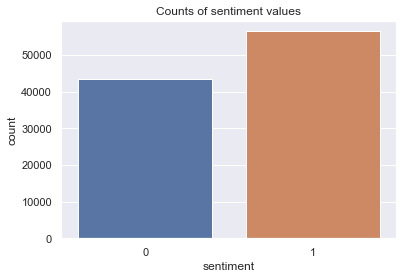

In [199]:
#Sentiment values percentage
sns.countplot(data.sentiment);
plt.title('Counts of sentiment values');

In [200]:
print('Distribution of sentiments')
data.sentiment.value_counts()*100/len(data)

Distribution of sentiments


1    56.463211
0    43.536789
Name: sentiment, dtype: float64

### Distribution of lengths

In [201]:
data['lengths'] = [len(str(t)) for t in data.tweet]

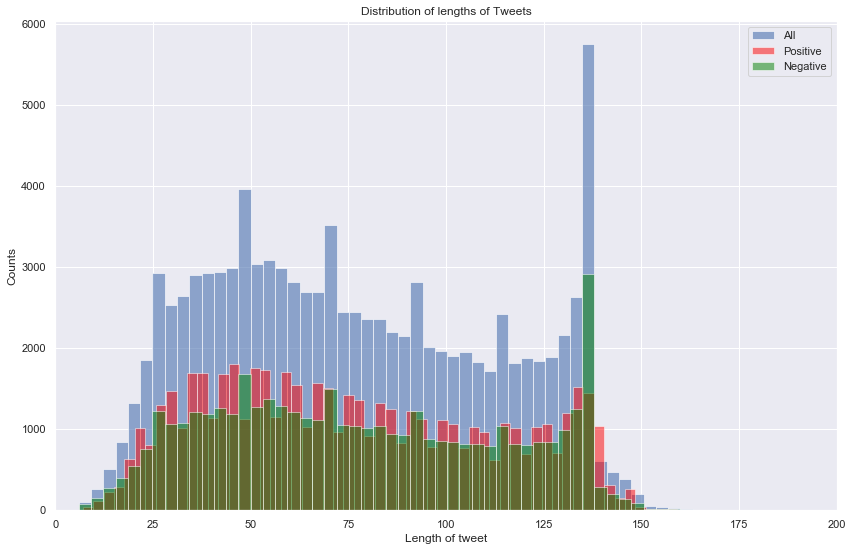

In [202]:
plt.figure(figsize=(14,9));
plt.xlim(0,200);
data.lengths.hist(density=False,bins=300,alpha=0.6,label='All');
data[data.sentiment==1].lengths.hist(density=False,bins=100,alpha=0.5,label='Positive',color='red');
data[data.sentiment==0].lengths.hist(density=False,bins=300,alpha=0.5,label='Negative',color='green');
plt.title('Distribution of lengths of Tweets')
plt.xlabel('Length of tweet')
plt.ylabel('Counts')
plt.legend();


### Inspecting negative sentiment

In [203]:
data[data.sentiment==0].sample(15,random_state=2)

,sentiment,tweet,processed_tweet,lengths
731,0,;( noooo! why? things are so complicated if I spelt that wrong idc,noo things complicate spell wrong idc,67
66061,0,@bliss_ke I did...sadness I wanna get my nose pierced I might just say fuck it and do it...lol or get another tat...idk yet,sadness wan na get nose pierce might say fuck lol get another tat idk yet,124
47358,0,@alltony no its the same day as edgefest lol TEXT ME i dont know why i dont have your number in my phone,day edgefest lol text dont know dont number phone,106
66528,0,"@blue_id_grl01 I know - very immature for people to react to ANY celeb that way, huh. Thank God he had security! He was so nice about it",know immature people react celeb way huh thank god security nice,137
24673,0,@acidcode i never even having known them...,never even know,44
6158,0,saddness let me no if i can,saddness let,28
29514,0,@acummings it was good although the $5 special is only pepperoni. Unfortunately they skimped on the sauce,good although special pepperoni unfortunately skimp sauce,106
24863,0,"@30SECONDSTOMARS wow you guys are cool for spreading the summit across the world,oh but you always forget out Scotland when you tour",wow guy cool spread summit across world oh always forget scotland tour,134
645,0,why me?,,9
425,0,Exercise 2 build muscle mass is only thing that speeds metabolism: http://tinyurl.com/bvagbj,exercise build muscle mass thing speed metabolism,94


### Inspecting positive sentiment

In [204]:
data[data.sentiment==1].sample(15,random_state=2)

,sentiment,tweet,processed_tweet,lengths
96224,1,@clarkrichard love david mead,love david mead,30
88188,1,@Cheep_Tweeter how are you today?,today,34
66082,1,"@bliumchik have you DMed your email to @fictioncrush yet? For a start, in case Loon's busy sleeping or looking pretty or something",dmed email yet start case loon busy sleep look pretty something,131
43844,1,@annamariaelings ours is clear across the country...its sad really. Too far away.,clear across country sad really far away,82
36742,1,"@alexdavispecial / if you decide to take lessons, check out our site for an instructor in your area. http://is.gd/LX2p",decide take lessons check site instructor area,121
77513,1,@cathydavidphoto I hear the 35 f/1.4 is great! It is my next purchase!,hear great next purchase,72
99847,1,@crystaljtorres only sundays?? I will miss you!!!! 1 besote Crystal!!,sundays miss besote crystal,70
8794,1,Yayz! Today's is the day I call and see if I got that job! x3 I ish so happy... even though I slept horribly... So I'm kinda drained...,yayz today day call see get job ish happy even though sleep horribly kinda drain,136
22393,1,@_most_wanted_ lol silly boy! I love you,lol silly boy love,41
97065,1,@CSI_PrintChick Hiya that's sweet that you are really CSI I thought it was just your tweet name...,hiya sweet really csi think tweet name,100


### Wordclouds

In [205]:
pos_data = data[data.sentiment==1]
neg_data = data[data.sentiment==0]
pos_text = ' '.join(str(t) for t in pos_data.processed_tweet)
neg_text = ' '.join(str(t) for t in neg_data.processed_tweet)

Positive Sentiment

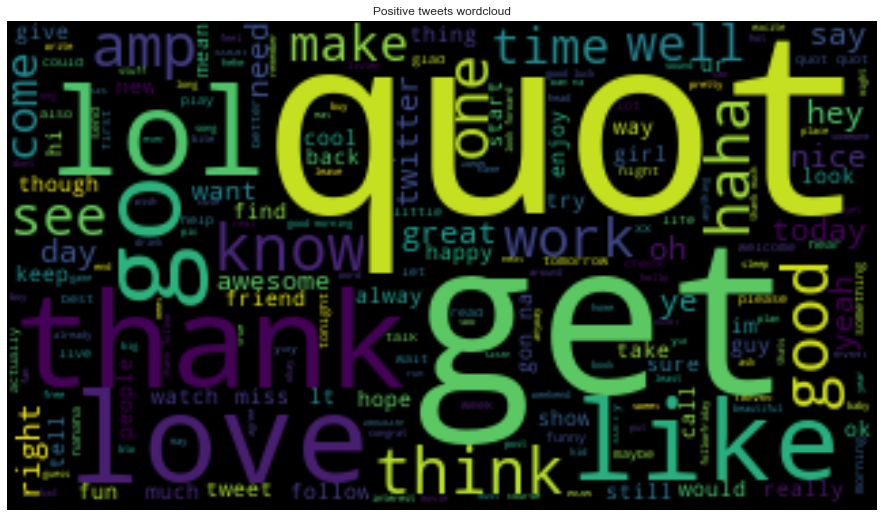

In [206]:
wc_pos = WordCloud(width=320,height=180,stopwords=stop_words).generate(pos_text)
plt.figure(figsize=(16,9))
plt.title('Positive tweets wordcloud')
plt.axis('off')
plt.imshow(wc_pos,interpolation='bilinear');

In [207]:
pos_d = get_wordcounts_df(pos_text,stop=False)

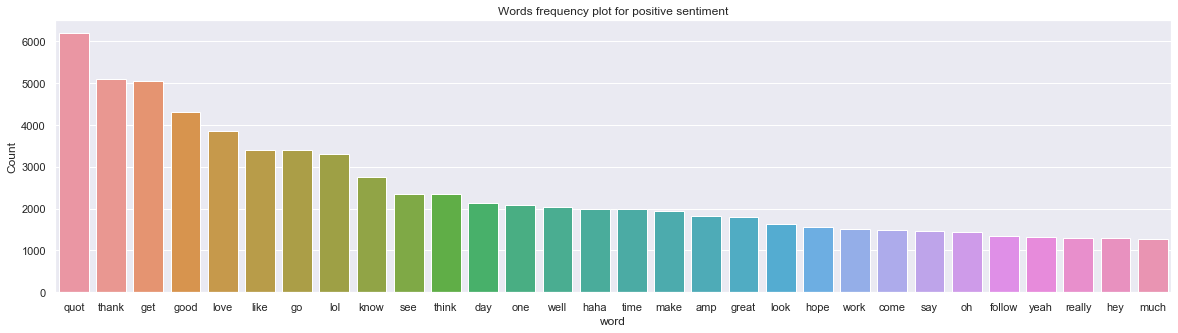

In [208]:
d = pos_d.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Words frequency plot for positive sentiment')
plt.show()

### Negative Sentiment

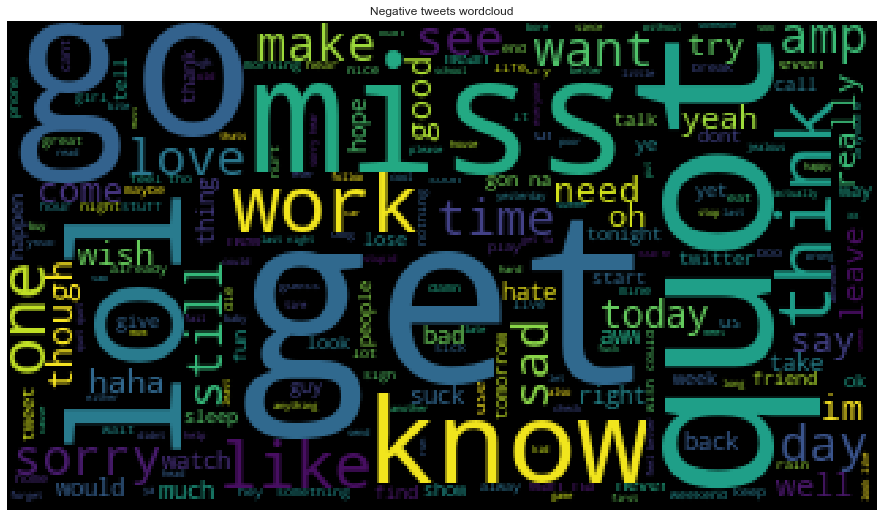

In [209]:
wc_neg = WordCloud(width=320,height=180,stopwords=stop_words).generate(neg_text)
plt.figure(figsize=(16,9))
plt.title('Negative tweets wordcloud')
plt.axis('off')
plt.imshow(wc_neg);

In [210]:
neg_d = get_wordcounts_df(neg_text,stop=False)

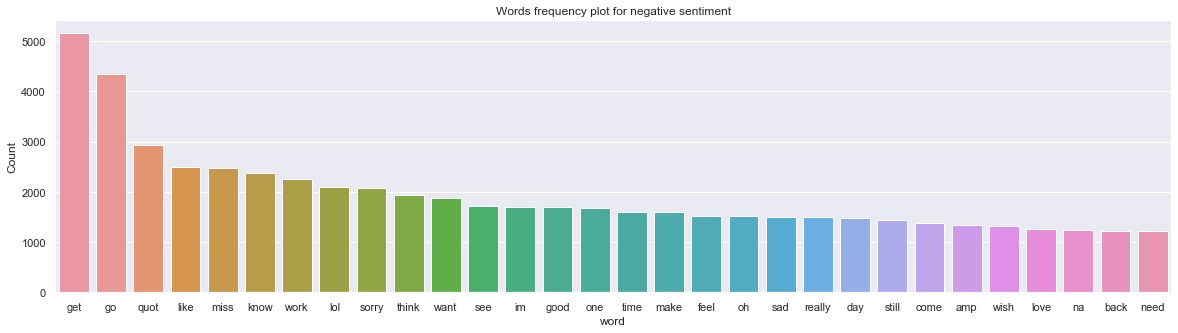

In [211]:
d = neg_d.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Words frequency plot for negative sentiment')
plt.show()

## Creating Model

In [8]:
RS = 42

### BOW

In [9]:
kf = KFold(n_splits=3,shuffle=True,random_state=RS)

In [10]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1),max_features=3000)
bow_tr = bow_vectorizer.fit_transform(data['processed_tweet'])

In [11]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow_tr,
                                                    data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=RS)

In [12]:
bow_models = train_and_cv_models(X_train_bow,y_train,nfolds=3,random_state=RS)

Training LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   11.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   12.2s finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   24.4s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.5s finished


Training XGB
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   22.1s remaining:   44.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   49.5s finished


Training NaiveBayes
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   19.3s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   20.1s finished


Trained all models


LOG_REG
Accuracy =  74.13741374137413
Confusion Matrix :
[[27.48274827 16.27162716]
 [ 9.5909591  46.65466547]]


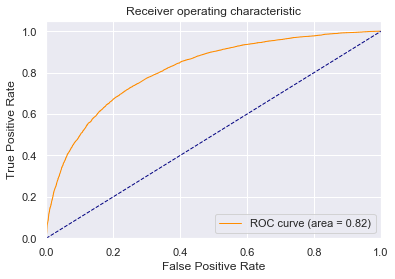

SVM
Accuracy =  74.19241924192418
Confusion Matrix :
[[27.87278728 15.88158816]
 [ 9.9259926  46.31963196]]


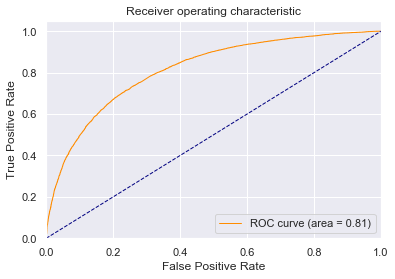

NB
Accuracy =  74.1024102410241
Confusion Matrix :
[[29.18791879 14.56645665]
 [11.33113311 44.91449145]]


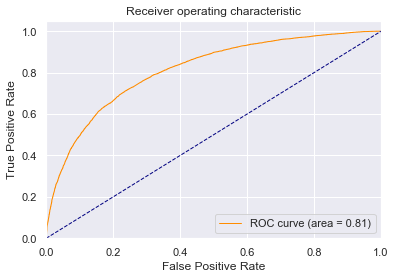

XGB
Accuracy =  71.2021202120212
Confusion Matrix :
[[21.40214021 22.35223522]
 [ 6.44564456 49.79998   ]]


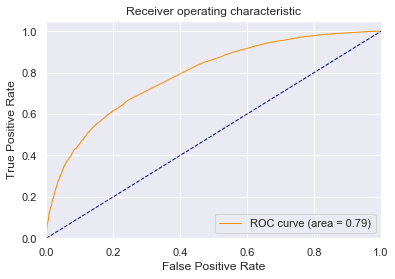

DT
Accuracy =  68.2018201820182
Confusion Matrix :
[[26.95269527 16.80168017]
 [14.99649965 41.24912491]]


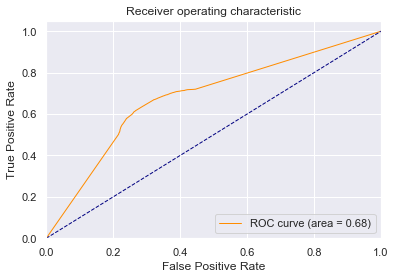

In [220]:
evaluate_models(bow_models,actual_y=y_test,test_data=X_test_bow)

In [221]:
extract_results_from_models('BOW',bow_models,y_test,X_test_bow)

,Method,Model,TrainAcc,CVAcc,TestAcc,TestF1,TestRecall,TestPrecision,TestROC_AUC
0,BOW,LOG_REG,0.769830,0.738096,0.741374,0.782981,0.829481,0.741418,0.815214
1,BOW,SVM,0.769580,0.736983,0.741374,0.782981,0.829481,0.741418,0.815214
2,BOW,NB,0.758942,0.737095,0.741024,0.776217,0.798542,0.755107,0.812639
3,BOW,XGB,0.733270,0.715168,0.712021,0.775714,0.885402,0.690207,0.788394
4,BOW,DT,0.976916,0.668888,0.682018,0.721792,0.733375,0.710569,0.682222


### TF-IDF

In [15]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(data['processed_tweet'])



In [16]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf,
                                                    data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=RS)

In [17]:
tfidif_models = train_and_cv_models(X_train_tfidf,y_train,nfolds=3,random_state=RS)

Training LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.0s finished


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   18.1s finished


Training XGB
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   21.4s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   54.5s finished


Training NaiveBayes
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   20.8s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.9s finished


Trained all models


LOG_REG
Accuracy =  74.35243524352435
Confusion Matrix :
[[27.99779978 15.75657566]
 [ 9.8909891  46.35463546]]


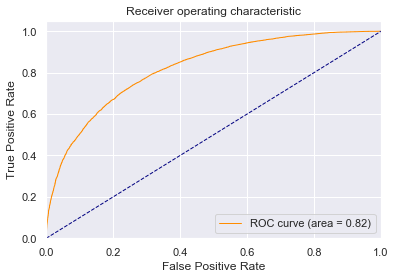

SVM
Accuracy =  72.19721972197219
Confusion Matrix :
[[20.73207321 23.02230223]
 [ 4.78047805 51.46514651]]


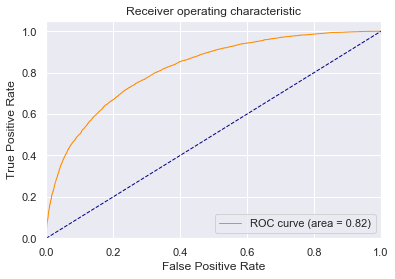

NB
Accuracy =  73.76737673767376
Confusion Matrix :
[[26.36263626 17.39173917]
 [ 8.84088409 47.40474047]]


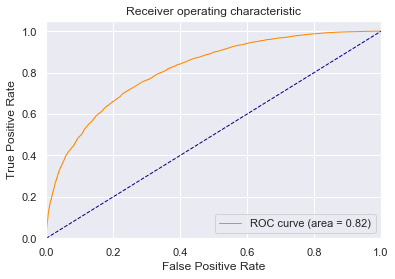

XGB
Accuracy =  70.98709870987099
Confusion Matrix :
[[21.35713571 22.39723972]
 [ 6.61566157 49.629963  ]]


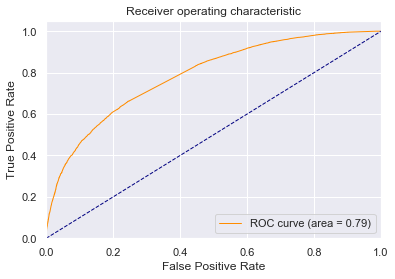

DT
Accuracy =  67.80178017801781
Confusion Matrix :
[[26.48264826 17.27172717]
 [14.92649265 41.31913191]]


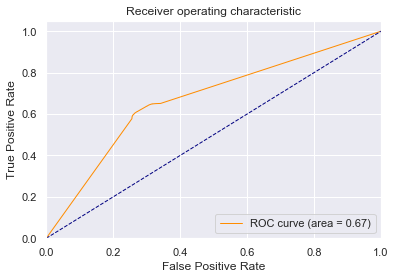

In [222]:
evaluate_models(tfidif_models,y_test,X_test_tfidf)

In [19]:
extract_results_from_models('TFIDF',tfidif_models,y_test,X_test_tfidf)

,Method,Model,TrainAcc,CVAcc,TestAcc,TestF1,TestRecall,TestPrecision,TestROC_AUC
0,TFIDF,LOG_REG,0.768249,0.739808,0.743524,0.783303,0.824147,0.746317,0.821860
1,TFIDF,SVM,0.767643,0.739871,0.743524,0.783303,0.824147,0.746317,0.821860
2,TFIDF,NB,0.758217,0.733157,0.737674,0.783277,0.842817,0.731594,0.816258
3,TFIDF,XGB,0.740615,0.715230,0.709871,0.773819,0.882379,0.689045,0.787071
4,TFIDF,DT,0.976722,0.671601,0.678018,0.719617,0.734619,0.705215,0.671574


### Word2Vec

In [20]:
model_w2v = gensim.models.Word2Vec(
            data.processed_tweet,
            size=1000, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 8, # no.of cores
            seed = RS)

model_w2v.train(data.processed_tweet, total_examples= len(data.processed_tweet), epochs=20)

(13086511, 74879980)

In [21]:
wordvec_arrays = np.zeros((len(data.processed_tweet), 1000))

for i in range(len(data.processed_tweet)):
    wordvec_arrays[i,:] = word_vector(data.processed_tweet[i], 1000)
    
#wordvec_df = pd.DataFrame(wordvec_arrays)
#wordvec_df.shape

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [58]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(np.ndarray.round(wordvec_arrays,3),
                                                    data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=RS)

In [60]:
word2vec_models = train_and_cv_models(X_train_w2v,y_train,nfolds=3,random_state=RS,w2v=True)

Training NaiveBayes
Training LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  5.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.4min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 13.5min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 20.6min finished


Training XGB
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.0min finished


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   56.4s remaining:   56.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.5min finished


Trained all models


LOG_REG
Accuracy =  58.89088908890889
Confusion Matrix :
[[10.65106511 33.10331033]
 [ 8.00580058 48.23982398]]


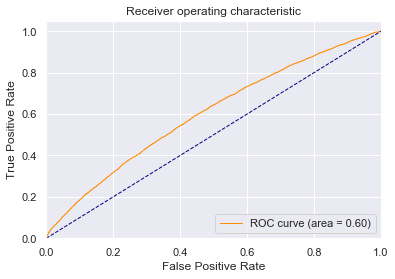

SVM
Accuracy =  47.4997499749975
Confusion Matrix :
[[40.91909191  2.83528353]
 [49.6649665   6.58065807]]


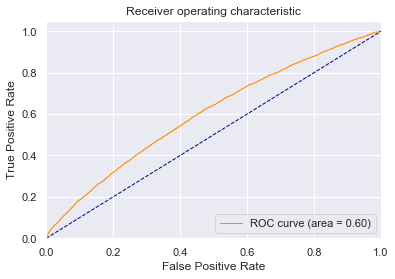

XGB
Accuracy =  60.21102110211021
Confusion Matrix :
[[13.25632563 30.4980498 ]
 [ 9.29092909 46.95469547]]


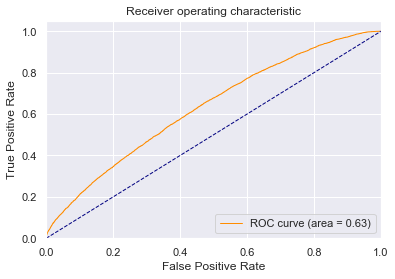

DT
Accuracy =  54.780478047804785
Confusion Matrix :
[[21.01710171 22.73727373]
 [22.48224822 33.76337634]]


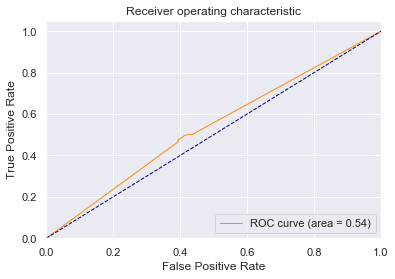

In [223]:
evaluate_models(word2vec_models,y_test,X_test_w2v)

In [224]:
extract_results_from_models('W2V',word2vec_models,actual=y_test,test=X_test_w2v)

,Method,Model,TrainAcc,CVAcc,TestAcc,TestF1,TestRecall,TestPrecision,TestROC_AUC
0,W2V,LOG_REG,0.595523,0.593554,0.588909,0.701218,0.857664,0.593041,0.601333
1,W2V,SVM,0.595561,0.592692,0.588909,0.701218,0.857664,0.593041,0.601333
2,W2V,XGB,0.627121,0.609594,0.602110,0.702397,0.834815,0.606237,0.632348
3,W2V,DT,0.988205,0.551437,0.547805,0.598927,0.600284,0.597575,0.535828


### Analysis of results

In [225]:
results = extract_results_from_models('BOW',bow_models,y_test,X_test_bow). \
append(extract_results_from_models('TFIDF',tfidif_models,y_test,X_test_tfidf)). \
append(extract_results_from_models('W2V',word2vec_models,actual=y_test,test=X_test_w2v)).reset_index(drop=True)

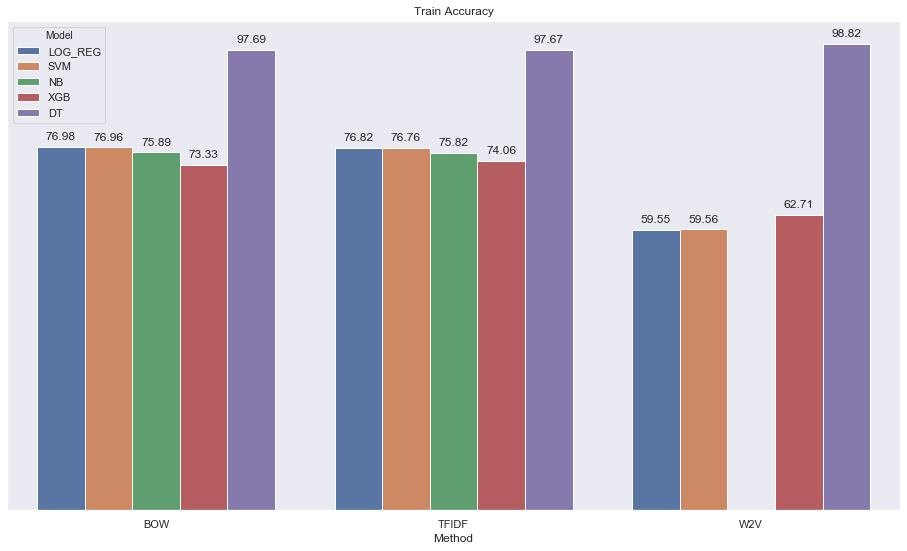

In [226]:
plot_model_metric(results,'TrainAcc','Train Accuracy')

In [227]:
results.set_index(['Method','Model'])

TrainAcc     CVAcc   TestAcc    TestF1  TestRecall  \
Method Model                                                         
BOW    LOG_REG  0.769830  0.738096  0.741374  0.782981    0.829481   
       SVM      0.769580  0.736983  0.741374  0.782981    0.829481   
       NB       0.758942  0.737095  0.741024  0.776217    0.798542   
       XGB      0.733270  0.715168  0.712021  0.775714    0.885402   
       DT       0.976916  0.668888  0.682018  0.721792    0.733375   
TFIDF  LOG_REG  0.768249  0.739808  0.743524  0.783303    0.824147   
       SVM      0.767643  0.739871  0.743524  0.783303    0.824147   
       NB       0.758217  0.733157  0.737674  0.783277    0.842817   
       XGB      0.740615  0.715230  0.709871  0.773819    0.882379   
       DT       0.976722  0.671601  0.678018  0.719617    0.734619   
W2V    LOG_REG  0.595523  0.593554  0.588909  0.701218    0.857664   
       SVM      0.595561  0.592692  0.588909  0.701218    0.857664   
       XGB      0.627121  0.609594  0.602110  0.702397    0.834815   
       DT       0.988205  0.551437  0.547805  0.598927    0.600284   

                TestPrecision  TestROC_AUC  
Method Model                                
BOW    LOG_REG       0.741418     0.815214  
       SVM           0.741418     0.815214  
       NB            0.755107     0.812639  
       XGB           0.690207     0.788394  
       DT            0.710569     0.682222  
TFIDF  LOG_REG       0.746317     0.821860  
       SVM           0.746317     0.821860  
       NB            0.731594     0.816258  
       XGB           0.689045     0.787071  
       DT            0.705215     0.671574  
W2V    LOG_REG       0.593041     0.601333  
       SVM           0.593041     0.601333  
       XGB           0.606237     0.632348  
       DT            0.597575     0.535828

### Final predictions

In [228]:
preds = tfidif_models['LOG_REG'].best_estimator_.predict(tfidf)

In [229]:
data['preds'] = preds

In [230]:
pd.DataFrame(classification_report(data.sentiment,data.preds,target_names=['Negative','Positive'],output_dict=True))

,Negative,Positive,micro avg,macro avg,weighted avg
f1-score,0.705046,0.796944,0.759474,0.750995,0.756934
precision,0.756302,0.761418,0.759474,0.758860,0.759191
recall,0.660296,0.835946,0.759474,0.748121,0.759474
support,43532.000000,56457.000000,99989.000000,99989.000000,99989.000000


In [231]:
data[(data.preds!=data.sentiment)][['sentiment','preds','tweet']].sample(10).reset_index(drop=True)

,sentiment,preds,tweet
0,0,1,@calliekins no time for the fam
1,0,1,@beautie: oooh sounds good. pricey? any other recommendations for good treatments/leave-in serums? i have a frizz problem
2,0,1,*sigh* no luck. best buy pays 1.20 more but for a ton more work.....though the day would move faster and the discount would be better.
3,0,1,#buzz140 is out the the trending topics...
4,0,1,@benjaminjtaylor : 7thgeneration post is gone but I do like to wipe the privates with em and clean the counters
5,1,0,"@beanandgone called at the Farmers Market in the rain this morning, didn't buy coffee, sorry, I'm a tea drinker really!"
6,0,1,@AndyHannon smoke a little for 420 and chill out!
7,1,0,@1ptilf I ate McDonald's today &amp; thought of you
8,0,1,"@ keener2u talking to my family abt u being in mclean, we luv mclean they had the combo gas station dairy queen....but it became mcdonds"
9,0,1,@ccatiedid me too
